In [1]:
import os
import cv2
import json
import torch
import pickle
import rasterio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
torch.multiprocessing.set_sharing_strategy('file_system')    

In [129]:
class MultiBandTiffDataset(ImageFolder):
    def __init__(self, root: str, json_path: str, transform=None):
        super().__init__(root, transform=transform)
        self.to_tensor = ToTensor()

        with open('data/ims/TreeSatBA_v9_60m_multi_labels.json') as inf:
            targets_dict = json.load(inf)
        
        self.targets_dict = {k: v for k, v in targets_dict.items()}

    def __getitem__(self, index):
        path, label = self.samples[index]        

        target_class_names, target_ratios = zip(*self.targets_dict[path.split('/')[-1]])
        target_idxs = [self.class_to_idx[t_c] for t_c in target_class_names]
        true_distrubution = torch.zeros((len(self.class_to_idx), 1))
        true_distrubution[target_idxs, 0] = torch.tensor(target_ratios)
        
        with rasterio.open(path) as src:
            image = src.read() 

        image = np.array(image, dtype=np.float32)
        image = (image - image.min(axis=1, keepdims=True)) / (image.max(axis=1, keepdims=True) - image.min(axis=1, keepdims=True))

        # image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        # cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        # image = np.uint8(image)

        
        if self.transform:
            image = self.transform(image)

        return image, label, true_distrubution


def load_pickled_ds(fname: str):
    
    with open(fname, 'rb') as f:
        x = pickle.load(f)

    return x

In [131]:
train_dataset = MultiBandTiffDataset(root='data/ims/sorted/s1_60m/train', json_path='data/ims/TreeSatBA_v9_60m_multi_labels.json') 
val_dataset = MultiBandTiffDataset(root='data/ims/sorted/s2_60m/test', json_path='data/ims/TreeSatBA_v9_60m_multi_labels.json')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=1)

In [23]:
X_train, y_train = [], []
X_val, y_val = [], []

full_distrib_train, full_distrib_val = [], []

for inputs, targets, true_distrib in tqdm(train_dataloader):
    X_train.append(inputs.numpy())
    y_train.append(targets.numpy())
    full_distrib_train.append(true_distrib.numpy())
    
for inputs, targets, true_distrib in tqdm(val_dataloader):
    X_val.append(inputs.numpy())
    y_val.append(targets.numpy())
    full_distrib_val.append(true_distrib.numpy())


X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
full_distrib_train = np.concatenate(full_distrib_train, axis=0)

X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)
full_distrib_val = np.concatenate(full_distrib_val, axis=0)

100%|██████████| 316/316 [00:04<00:00, 78.99it/s]


In [24]:
X_train.shape

(45337, 6, 6, 3)

In [19]:
with open('data/pickled_data/raw_train_test_splitted_s1_60.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, full_distrib_train, X_val, y_val, full_distrib_val), f)

In [9]:
X_train, y_train, full_distrib_train, X_val, y_val, full_distrib_val = load_pickled_ds('data/pickled_data/raw_train_test_splitted_s2_60.pkl')

In [10]:
X_train, y_train, full_distrib_train, X_val, y_val, full_distrib_val = load_pickled_ds('data/pickled_data/raw_train_test_splitted_s1_60.pkl')

In [11]:
ds_classes = ['Abies',
              'Acer',
              'Alnus',
              'Betula',
              'Cleared',
              'Fagus',
              'Fraxinus',
              'Larix',
              'Picea',
              'Pinus',
              'Populus',
              'Prunus',
              'Pseudotsuga',
              'Quercus',
              'Tilia']

Text(0.5, 1.0, 'Val_distro')

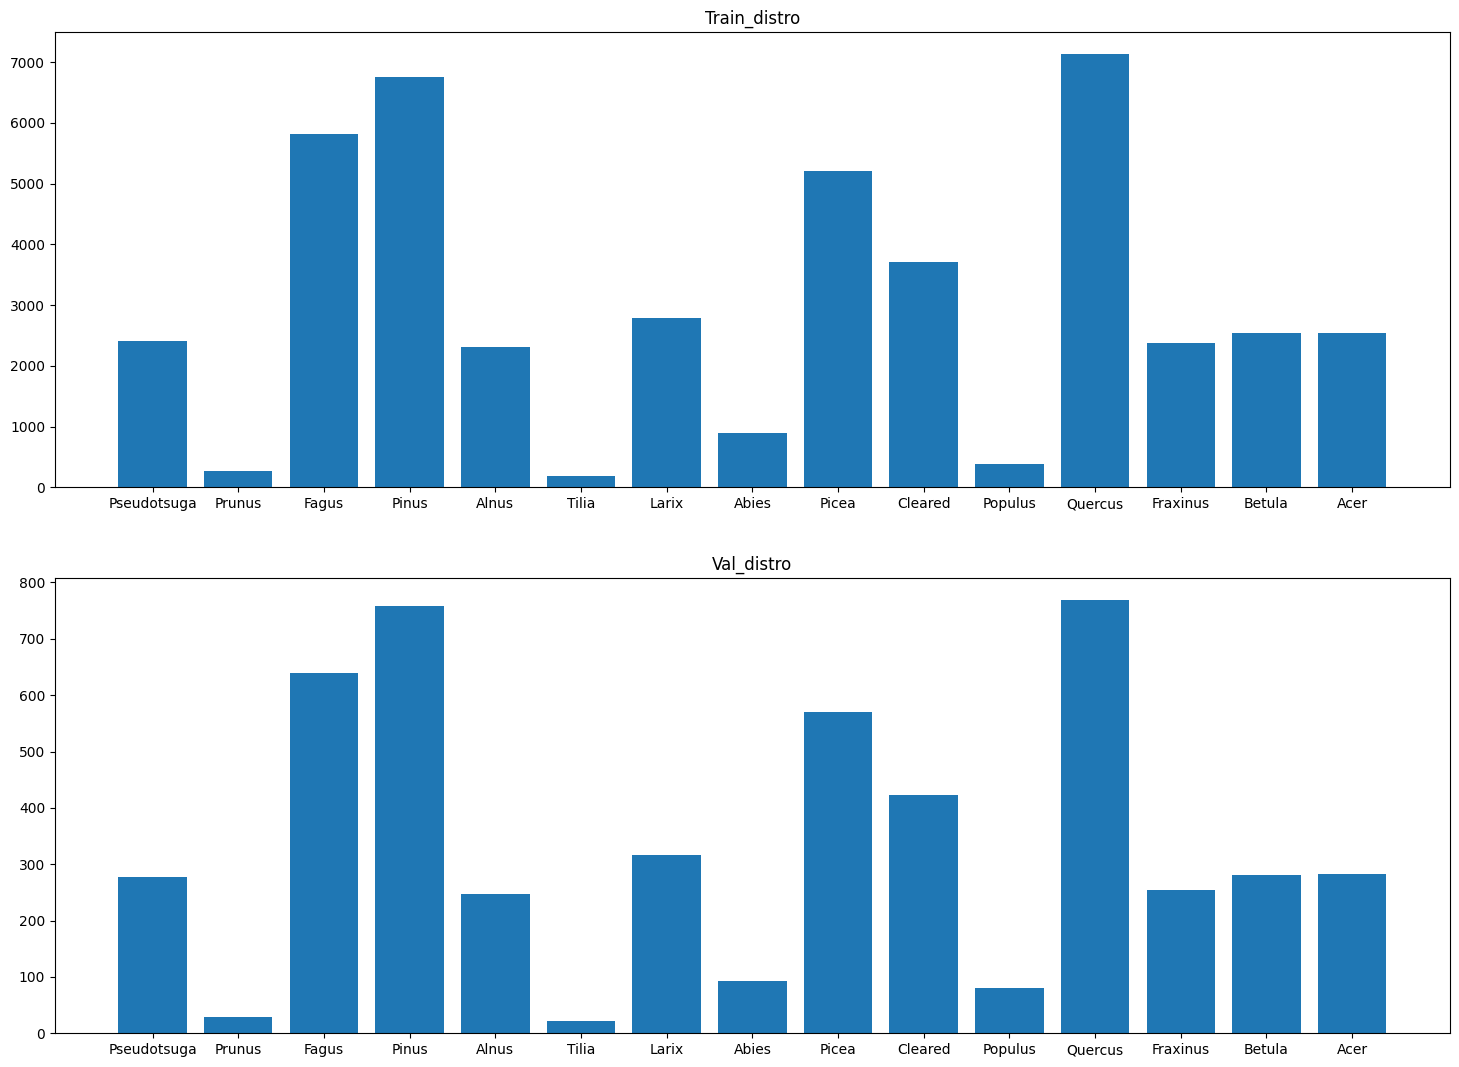

In [12]:

class_names = os.listdir('data/ims/sorted/s1_60m/train/')

class_counts_train = [len(os.listdir(os.path.join('data/ims/sorted/s1_60m/train/', class_name))) for class_name in class_names]
class_counts_val = [len(os.listdir(os.path.join('data/ims/sorted/s1_60m/test/', class_name))) for class_name in class_names]

f, ax = plt.subplots(2, 1, figsize=(18, 13))

ax[0].bar(class_names, class_counts_train)
ax[0].set_title('Train_distro')

ax[1].bar(class_names, class_counts_val)
ax[1].set_title('Val_distro')

Text(0.5, 1.0, 'Val_distro')

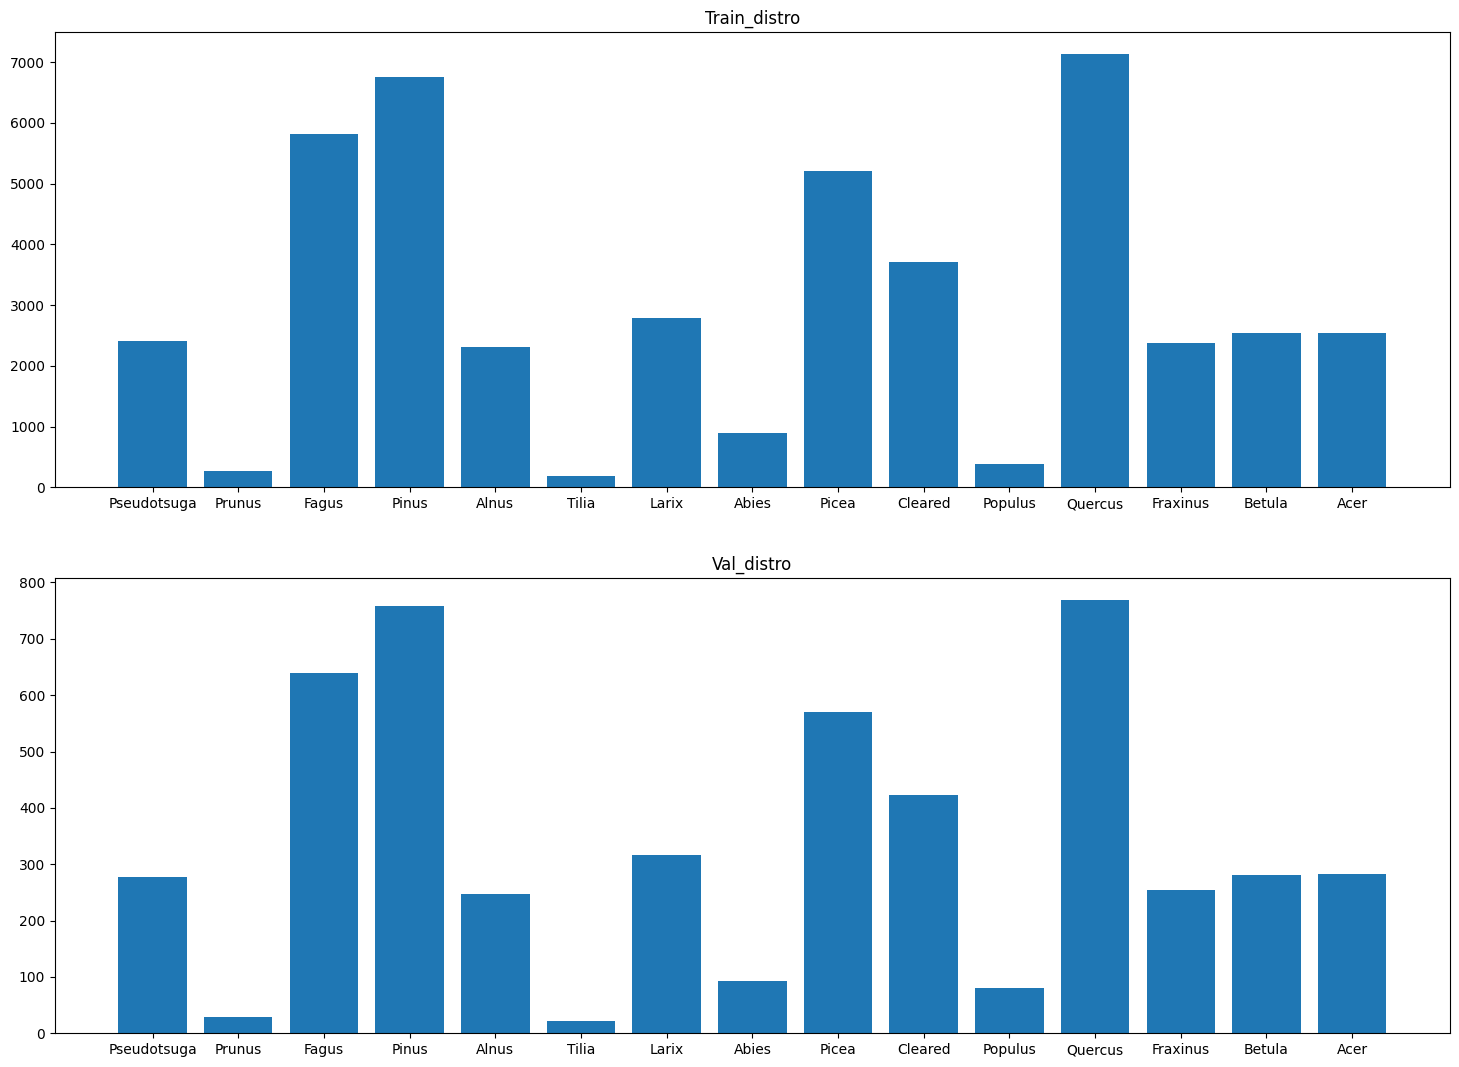

In [23]:

class_names = os.listdir('data/ims/sorted/s2_60m/train/')

class_counts_train = [len(os.listdir(os.path.join('data/ims/sorted/s2_60m/train/', class_name))) for class_name in class_names]
class_counts_val = [len(os.listdir(os.path.join('data/ims/sorted/s2_60m/test/', class_name))) for class_name in class_names]

f, ax = plt.subplots(2, 1, figsize=(18, 13))

ax[0].bar(class_names, class_counts_train)
ax[0].set_title('Train_distro')

ax[1].bar(class_names, class_counts_val)
ax[1].set_title('Val_distro')